In [1]:
import os
import sys

sys.path.insert(0,'/Users/jmelvin/install/homebrew/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/')

import tecplot as tec
import netCDF4 as nc
import pandas as pd
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
def CDPprocessDS(fname):
  dset = tec.data.load_tecplot(fname,read_data_option=tec.constant.ReadDataOption.Replace)
  zone = dset.zone_names[0]
  print zone
  x = dset.variable('X').values(zone)
  y = dset.variable('Y').values(zone)
  z = dset.variable('Z').values(zone)
  ux = dset.variable('U-X').values(zone)
  uy = dset.variable('U-Y').values(zone)
  uz = dset.variable('U-Z').values(zone)
  avgUx = dset.variable('U_AVERAGE-X').values(zone)
  avgUy = dset.variable('U_AVERAGE-Y').values(zone)
  avgUz = dset.variable('U_AVERAGE-Z').values(zone)
  alpha = dset.variable('K_RATIO').values(zone)
  tke = dset.variable('TKE').values(zone)
  tdr = dset.variable('TDR').values(zone)
  rk = dset.variable('FD').values(zone)
  avgRk = dset.variable('FD_AVE').values(zone)
  kres = dset.variable('K_RESOLVED').values(zone)
  avgProd = dset.variable('PROD_C').values(zone)
  tvisc = dset.variable('NU_T').values(zone)
  timeDES = dset.variable('TIME_DES').values(zone)
  v2 = dset.variable('V2F_V2').values(zone)
    
  rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'rk':rk[:],'avgRk':avgRk[:],'kres':kres[:],'avgProd':avgProd[:],'tvisc':tvisc[:],'timeDES':timeDES[:],'v2':v2[:]})
  #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'rk':rk[:],'avgRk':avgRk[:],'kres':kres[:],'avgProd':avgProd[:],'tvisc':tvisc[:]})
  rawdata = rawdata.round(10)
    
  rawdata["fluctUx"] = rawdata["ux"] - rawdata["avgUx"]
  rawdata["fluctUy"] = rawdata["uy"] - rawdata["avgUy"]
  rawdata["fluctUz"] = rawdata["uz"] - rawdata["avgUz"]
  rawdata["varUx"] = rawdata["fluctUx"]*rawdata["fluctUx"]
  rawdata["varUy"] = rawdata["fluctUy"]*rawdata["fluctUy"]
  rawdata["varUz"] = rawdata["fluctUz"]*rawdata["fluctUz"]
  rawdata["altTvisc"] = 0.22*rawdata["v2"]*rawdata["timeDES"]

  return rawdata

def plotCDPdataset(rdata,var,log,visc,plotHere,save):
  Retau = 1.0/visc #assumes a channel height of 1 and a utau of 1.0
  yCoords = rdata.y.unique()
    
  planarAvg = np.zeros((len(yCoords),21))
  index = 0
  for yc in yCoords:
    sliceY = rdata.loc[(rdata['y'] == yc)]
    avgUx = sliceY.ux.sum()/len(sliceY)
    avgUy = sliceY.uy.sum()/len(sliceY)
    avgUz = sliceY.uz.sum()/len(sliceY)
    avgAvgUx = sliceY.avgUx.sum()/len(sliceY)
    avgAvgUy = sliceY.avgUy.sum()/len(sliceY)
    avgAvgUz = sliceY.avgUz.sum()/len(sliceY)
    avgAlpha = sliceY.alpha.sum()/len(sliceY)
    avgTke = sliceY.tke.sum()/len(sliceY)
    avgTdr = sliceY.tdr.sum()/len(sliceY)
    avgRk = sliceY.rk.sum()/len(sliceY)
    avgAvgRk = sliceY.avgRk.sum()/len(sliceY)
    avgKres = sliceY.kres.sum()/len(sliceY)
    avgAvgProd = sliceY.avgProd.sum()/len(sliceY)
    avgTvisc = sliceY.tvisc.sum()/len(sliceY)
    avgAltTvisc = sliceY.altTvisc.sum()/len(sliceY)
    avgTimeDES = sliceY.timeDES.sum()/len(sliceY)
    avgV2 = sliceY.v2.sum()/len(sliceY)
    uuVar = sliceY.varUx.sum()/len(sliceY)
    vvVar = sliceY.varUy.sum()/len(sliceY)
    wwVar = sliceY.varUz.sum()/len(sliceY)
    planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,avgTdr,avgRk,avgAvgRk,avgKres,avgAvgProd,avgTvisc,avgAltTvisc,avgTimeDES,avgV2,uuVar,vvVar,wwVar])
    #planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,avgRk,avgAvgRk,avgKres,avgAvgProd,avgTvisc])
    index = index + 1
    
  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUx','alpha','tke','tdr','rk','avgRk','kres','avgProd','tvisc','altTvisc','timeDES','v2','uuVar','vvVar','wwVar'])
  #pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUx','alpha','tke','rk','avgRk','kres','avgProd','tvisc'])
  
  pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig = plt.figure()
      ax = fig.add_subplot(1,1,1)
      ax.plot(pltFrame.y,pltFrame[var])

      if (log):
          ax.set_xscale('log')
      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/cdp_' + zone[5:-1])
          plt.close(fig)
        
      if (not save):
          plt.show()

  return pltFrame


def NALUprocessDS(bname,numPart,ts):
    for j in range(0,numPart):
        if (numPart > 1):
            fn = bname + "." + str(numPart) + "." + str(j).zfill(2)
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']
            
            #print j

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "total_dissipation_rate"):
                    tdr = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_tke_resolved"):
                    kres = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_production"):
                    avgProd = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_viscosity"):
                    tvisc = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "resolution_adequacy_parameter"):
                    rk = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "avg_res_adequacy_parameter"):
                    avgRk = f["vals_nod_var%i" % (i+1)][ts]
            for i in range(0,f.dimensions["num_elem_var"].size):
                if (''.join(f["name_elem_var"][i].data) == "resolution_adequacy_parameter"):
                    rkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalRk = np.zeros(f.dimensions["num_nodes"].size)
                    countRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalRk[nodeID-1] += rkElem[elemCnt]
                            countRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    rk = nodalRk/countRk
                if (''.join(f["name_elem_var"][i].data) == "average_resolution_adequacy_para"):
                    avgRkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    countAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalAvgRk[nodeID-1] += avgRkElem[elemCnt]
                            countAvgRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    avgRk = nodalAvgRk/countAvgRk
 
            if (j == 0):
                print f["time_whole"][ts]
                rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'avgProd':avgProd[:],'tvisc':tvisc[:],'rk':rk[:],'avgRk':avgRk[:]})
                #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'tke':tke[:],'tvisc':tvisc[:]})
                #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'tvisc':tvisc[:]})
            else:
                tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'avgProd':avgProd[:],'tvisc':tvisc[:],'rk':rk[:],'avgRk':avgRk[:]})
                #tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'tke':tke[:],'tvisc':tvisc[:]})
                #tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'kres':kres[:],'tvisc':tvisc[:]})
                rawdata = pd.concat([rawdata,tmpdata])
        
        else:
            fn = bname
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            print f["time_whole"][ts]

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "total_dissipation_rate"):
                    tdr = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_tke_resolved"):
                    kres = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_production"):
                    avgProd = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_viscosity"):
                    tvisc = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "resolution_adequacy_parameter"):
                    rk = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "avg_res_adequacy_parameter"):
                    avgRk = f["vals_nod_var%i" % (i+1)][ts]
            for i in range(0,f.dimensions["num_elem_var"].size):
                if (''.join(f["name_elem_var"][i].data) == "resolution_adequacy_parameter"):
                    rkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalRk = np.zeros(f.dimensions["num_nodes"].size)
                    countRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalRk[nodeID-1] += rkElem[elemCnt]
                            countRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    rk = nodalRk/countRk
                if (''.join(f["name_elem_var"][i].data) == "average_resolution_adequacy_para"):
                    avgRkElem = f["vals_elem_var%ieb1" % (i+1)][ts]
                    nodalAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    countAvgRk = np.zeros(f.dimensions["num_nodes"].size)
                    elemCnt = 0
                    for elem in f["connect1"][:]:
                        for nodeID in elem:
                            nodalAvgRk[nodeID-1] += avgRkElem[elemCnt]
                            countAvgRk[nodeID-1] += 1
                        elemCnt = elemCnt + 1
                    avgRk = nodalRk/countRk  
                    
            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'rk':rk[:],'avgRk':avgRk[:],'kres':kres[:],'avgProd':avgProd[:],'tvisc':tvisc[:],'rk':rk[:],'avgRk':avgRk[:]})
            #rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'tke':tke[:],'tvisc':tvisc[:]})

#            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:],'tdr':tdr[:],'rk':rk[:],'avgRk':avgRk[:],'kres':kres[:],'tvisc':tvisc[:]})

    rawdata = rawdata.round(10)
    rawdata["fluctUx"] = rawdata["ux"] - rawdata["avgUx"]
    rawdata["fluctUy"] = rawdata["uy"] - rawdata["avgUy"]
    rawdata["fluctUz"] = rawdata["uz"] - rawdata["avgUz"]
    rawdata["varUx"] = rawdata["fluctUx"]*rawdata["fluctUx"]
    rawdata["varUy"] = rawdata["fluctUy"]*rawdata["fluctUy"]
    rawdata["varUz"] = rawdata["fluctUz"]*rawdata["fluctUz"]
    
    return rawdata


def plotNaludataset(rdata,var,log,visc,ts,plotHere,save):
  Retau = 1.0/visc #assumes a channel halfwidth of 1 and a utau of 1.0
  yCoords = rdata.y.unique()
    
  planarAvg = np.zeros((len(yCoords),18))
  index = 0
  for yc in yCoords:
      sliceY = rdata.loc[(rdata['y'] == yc)]
      avgUx = sliceY.ux.sum()/len(sliceY)
      avgUy = sliceY.uy.sum()/len(sliceY)
      avgUz = sliceY.uz.sum()/len(sliceY)
      avgAvgUx = sliceY.avgUx.sum()/len(sliceY)
      avgAvgUy = sliceY.avgUy.sum()/len(sliceY)
      avgAvgUz = sliceY.avgUz.sum()/len(sliceY)
      avgAlpha = sliceY.alpha.sum()/len(sliceY)
      avgTke = sliceY.tke.sum()/len(sliceY)
      avgTdr = sliceY.tdr.sum()/len(sliceY)
      avgRk = sliceY.rk.sum()/len(sliceY)
      avgAvgRk = sliceY.avgRk.sum()/len(sliceY)
      avgKres = sliceY.kres.sum()/len(sliceY)
      avgAvgProd = sliceY.avgProd.sum()/len(sliceY)
      avgTvisc = sliceY.tvisc.sum()/len(sliceY)
      uuVar = sliceY.varUx.sum()/len(sliceY)
      vvVar = sliceY.varUy.sum()/len(sliceY)
      wwVar = sliceY.varUz.sum()/len(sliceY)
      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,uuVar,vvVar,wwVar,avgTdr,avgKres,avgAvgProd,avgTvisc,avgRk,avgAvgRk])
#      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgTke,avgTvisc])
#      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,uuVar,vvVar,wwVar,avgTdr,avgKres,avgTvisc])
      index = index + 1
    
  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','uuVar','vvVar','wwVar','tdr','kres','avgProd','tvisc','rk','avgRk'])
#  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','tke','tvisc'])
#  pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','uu','vv','ww','tdr','kres','tvisc'])
    
  pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig = plt.figure()
      ax = fig.add_subplot(1,1,1)
      ax.plot(pltFrame.y,pltFrame[var])
      #ax.set_ylim(0.0,25.0)

      if (log):
          ax.set_xscale('log')
      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()

  return pltFrame

def DSplotCDP(fnameCDP,var,log,visc,ts,save,DNS,dnsPath):
  cdpData = CDPprocessDS(fnameCDP)
  cdpPlot = plotCDPdataset(cdpData,var,log,visc,False,False)
#  if (var != "forcing"):
  fig, ax = plt.subplots()
  ax.plot(cdpPlot.y,cdpPlot[var],'b',linewidth=4)
  if (DNS):
    DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
    if (var == 'tke'):
        ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)
    elif (var == 'ux'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
    elif (var == 'avgUx'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
  ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
  if (log):
      ax.set_xscale('log')
      ax.set_xlim([1, 1./visc])
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDP_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue"
      plt.show()
    
def DSplotCDPvsNalu(fnameCDP,bnameNalu,numPartNalu,var,log,visc,ts,save,DNS,dnsPath,customAxes,xL,xH,yL,yH):
  cdpData = CDPprocessDS(fnameCDP)
  #naluData = NALUprocessDS(bnameNalu,numPartNalu,ts)
  cdpPlot = plotCDPdataset(cdpData,var,log,visc,False,False)
  #naluPlot = plotNaludataset(naluData,var,log,visc,ts,False,False)
#  if (var != "forcing"):
  fig, ax = plt.subplots()
  ax.plot(cdpPlot.y,cdpPlot[var],'b',linewidth=4)
  #if (var == 'altTvisc'):
  #  ax.plot(naluPlot.y,naluPlot['tvisc'],'r',linewidth=4)
  #else:
  #  ax.plot(naluPlot.y,naluPlot[var],'r',linewidth=4)
  if (DNS):
    DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
    if (var == 'tke'):
        ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)
    elif (var == 'ux'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
    elif (var == 'avgUx'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
  ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
  if (log):
      ax.set_xscale('log')
      ax.set_xlim([1, 1./visc])
  if (customAxes):
      ax.set_xlim(xL,xH)
      ax.set_ylim(yL,yH)
#  else:
#      fig = plt.figure()
#      ax1 = plt.subplot(311)
#      ax1.plot(cdpPlot.y,cdpPlot['fxfx'])
#      ax1.plot(naluPlot.y,naluPlot['fxfx'])
#      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
#      ax2 = plt.subplot(312)
#      ax2.plot(cdpPlot.y,cdpPlot['fyfy'])
#      ax2.plot(naluPlot.y,naluPlot['fyfy'])
#      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
#      ax3 = plt.subplot(313)
#      ax3.plot(cdpPlot.y,cdpPlot['fzfz'])
#      ax3.plot(naluPlot.y,naluPlot['fzfz'])
#      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()
        
def DSplotNaluvsNalu(bnameNalu1,numPartNalu1,bnameNalu2,numPartNalu2,var,log,visc,ts,save,DNS,dnsPath,customAxes,xL,xH,yL,yH):
  naluData1 = NALUprocessDS(bnameNalu1,numPartNalu1,ts)
  naluData2 = NALUprocessDS(bnameNalu2,numPartNalu2,ts)
  naluPlot1 = plotNaludataset(naluData1,var,log,visc,ts,False,False)
  naluPlot2 = plotNaludataset(naluData2,var,log,visc,ts,False,False)
#  if (var != "forcing"):
  fig, ax = plt.subplots()
  ax.plot(naluPlot1.y,naluPlot1[var],'b',linewidth=4)
  ax.plot(naluPlot2.y,naluPlot2[var],'r',linewidth=4)
  if (DNS):
    DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
    if (var == 'tke'):
        ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)
    elif (var == 'ux'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
    elif (var == 'avgUx'):
        ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
  ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
  ax.set_xlim(1,1/visc)
  if (log):
      ax.set_xscale('log')
  if (customAxes):
      ax.set_xlim(xL,xH)
      ax.set_ylim(yL,yH)
#  else:
#      fig = plt.figure()
#      ax1 = plt.subplot(311)
#      ax1.plot(cdpPlot.y,cdpPlot['fxfx'])
#      ax1.plot(naluPlot.y,naluPlot['fxfx'])
#      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
#      ax2 = plt.subplot(312)
#      ax2.plot(cdpPlot.y,cdpPlot['fyfy'])
#      ax2.plot(naluPlot.y,naluPlot['fyfy'])
#      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
#      ax3 = plt.subplot(313)
#      ax3.plot(cdpPlot.y,cdpPlot['fzfz'])
#      ax3.plot(naluPlot.y,naluPlot['fzfz'])
#      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/NaluvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      plt.show()

In [4]:
stepNum = 10
dnsfn = '/Users/jmelvin/Desktop/WorkFromHome/Re5200.txt'
cdpfn = '/Users/jmelvin/Desktop/WorkFromHome/CDP-Re5200/TAMS-SST5200.120000.plt'
nalubn = '/workspace/jmelvin/Research/dataFiles/Nalu-Best_52219/TAMS-KEps-Re1000_52219.e'
naluNP = 32
visco = 0.000192831 # 0.000999488 # 0.000192831 
DSplotCDPvsNalu(cdpfn,nalubn,naluNP,"ux",False,visco,stepNum,False,True,dnsfn,False,100,1000,0,2)

TecplotLibraryNotFoundError: The Tecplot batch library or one of its dependencies could not be
found. This is usually the result of not setting the environment
path DYLD_LIBRARY_PATH to the directory containing the tecplot
executables.

DYLD_LIBRARY_PATH=/Users/jmelvin/Applications/bcvtb/lib/dummy:/Users/jmelvin/Applications/bcvtb/lib/util:

Batch library file name(s):
    libtecutilbatch.so
    libtecutilchecked.so


In [3]:
def NALUprocessDS(bname,numPart,var,log,visc,ts,save):
    Retau = 1.0/visc #assumes a channel height of 1 and a utau of 1.0
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for j in range(0,numPart):
        if (numPart > 1):
            fn = bname + "." + str(numPart) + "." + str(j).zfill(2)
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
 
            if (j == 0):
                print f["time_whole"][ts]
                rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:]})
            else:
                tmpdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:]})
                rawdata = pd.concat([rawdata,tmpdata])
        
        else:
            fn = bname
            f = nc.Dataset(fn,"r")
    
            x = f['coordx']
            y = f['coordy']
            z = f['coordz']

            print f["time_whole"][ts]

            for i in range(0,f.dimensions["num_nod_var"].size):
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_x"):
                    avgUx = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_y"):
                    avgUy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "average_velocity_z"):
                    avgUz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_x"):
                    ux = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_y"):
                    uy = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "velocity_z"):
                    uz = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "k_ratio"):
                    alpha = f["vals_nod_var%i" % (i+1)][ts]
                if (''.join(f["name_nod_var"][i].data) == "turbulent_ke"):
                    tke = f["vals_nod_var%i" % (i+1)][ts]
    
            rawdata = pd.DataFrame({'x':x[:],'y':y[:],'z':z[:],'ux':ux[:],'uy':uy[:],'uz':uz[:],'avgUx':avgUx[:],'avgUy':avgUy[:],'avgUz':avgUz[:],'alpha':alpha[:],'tke':tke[:]})

    rawdata = rawdata.round(10)
    yCoords = rawdata.y.unique()
    rawdata["fluctUx"] = rawdata["ux"] - rawdata["avgUx"]
    rawdata["fluctUy"] = rawdata["uy"] - rawdata["avgUy"]
    rawdata["fluctUz"] = rawdata["uz"] - rawdata["avgUz"]
    rawdata["varUx"] = rawdata["fluctUx"]*rawdata["fluctUx"]
    rawdata["varUy"] = rawdata["fluctUy"]*rawdata["fluctUy"]
    rawdata["varUz"] = rawdata["fluctUz"]*rawdata["fluctUz"]
    
    #print rawdata
    
    planarAvg = np.zeros((len(yCoords),12))
    index = 0
    for yc in yCoords:
      sliceY = rawdata.loc[(rawdata['y'] == yc)]
      avgUx = sliceY.ux.sum()/len(sliceY)
      avgUy = sliceY.uy.sum()/len(sliceY)
      avgUz = sliceY.uz.sum()/len(sliceY)
      avgAvgUx = sliceY.avgUx.sum()/len(sliceY)
      avgAvgUy = sliceY.avgUy.sum()/len(sliceY)
      avgAvgUz = sliceY.avgUz.sum()/len(sliceY)
      avgAlpha = sliceY.alpha.sum()/len(sliceY)
      avgTke = sliceY.tke.sum()/len(sliceY)
      uuVar = sliceY.varUx.sum()/len(sliceY)
      vvVar = sliceY.varUy.sum()/len(sliceY)
      wwVar = sliceY.varUz.sum()/len(sliceY)
      planarAvg[index] = np.array([yc/visc,avgUx,avgUy,avgUz,avgAvgUx,avgAvgUy,avgAvgUz,avgAlpha,avgTke,uuVar,vvVar,wwVar])
      index = index + 1
    
    pltFrame = pd.DataFrame(planarAvg,columns=['y','ux','uy','uz','avgUx','avgUy','avgUz','alpha','tke','uu','vv','ww'])
    
    pltFrame = pltFrame.loc[(pltFrame['y'] <= 1.0/visc)]
    pltFrame = pltFrame.sort_values(by=['y'])
    
    ax.plot(pltFrame.y,pltFrame[var])
    #ax.set_ylim(0.0,25.0)

    if (log):
        ax.set_xscale('log')
    if (save):
        plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
        plt.close(fig)
    else:
        plt.show()
        
    return pltFrame

In [15]:
files=[]
for i in range(0, 353):
    files.append("/workspace/jmelvin/meshes/HYB-KEPS1000." + str(10000+i*50).zfill(6) + ".plt")
print files
CDPprocessDS(files,"alpha",True,0.000999488,True)

['/workspace/jmelvin/meshes/HYB-KEPS1000.010000.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010050.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010100.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010150.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010200.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010250.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010300.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010350.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010400.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010450.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010500.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010550.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010600.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010650.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010700.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010750.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010800.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.010850.plt', '/workspace/jmelvin/meshes/HYB-KEPS1000.01090

step 010050
step 010100
step 010150
step 010200
step 010250
step 010300
step 010350
step 010400
step 010450
step 010500
step 010550
step 010600
step 010650
step 010700
step 010750
step 010800
step 010850
step 010900
step 010950
step 011000
step 011050
step 011100
step 011150
step 011200
step 011250
step 011300
step 011350
step 011400
step 011450
step 011500
step 011550
step 011600
step 011650
step 011700
step 011750
step 011800
step 011850
step 011900
step 011950
step 012000
step 012050
step 012100
step 012150
step 012200
step 012250
step 012300
step 012350
step 012400
step 012450
step 012500
step 012550
step 012600
step 012650
step 012700
step 012750
step 012800
step 012850
step 012900
step 012950
step 013000
step 013050
step 013100
step 013150
step 013200
step 013250
step 013300
step 013350
step 013400
step 013450
step 013500
step 013550
step 013600
step 013650
step 013700
step 013750
step 013800
step 013850
step 013900
step 013950
step 014000
step 014050
step 014100
step 014150
step

<Figure size 432x288 with 0 Axes>

540.2999999996468


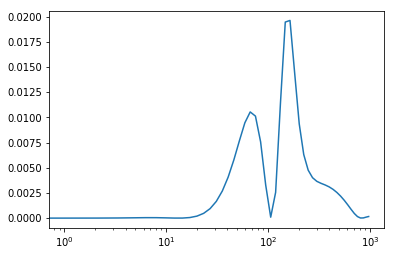

In [68]:
bn = "/workspace/jmelvin/meshes/TAMS_KE-Channel-BUGFIX.e"
naluFrame = NALUprocessDS(bn,32,"uu",True,0.000999488,15,False)

In [151]:
bn = "/workspace/jmelvin/meshes/TAMS_KE-Channel-numerics.e"
for i in range(0,550):
  NALUprocessDS(bn,32,"alpha",True,0.000999488,i,True)

539.9999999996539
540.4999999996535
540.999999999653
541.4999999996526
541.9999999996521
542.4999999996517
542.9999999996512
543.4999999996508
543.9999999996503
544.4999999996498
544.9999999996494
545.4999999996489
545.9999999996485
546.499999999648
546.9999999996476
547.4999999996471
547.9999999996467
548.4999999996462
548.9999999996458
549.4999999996453
549.9999999996448
550.4999999996444
550.9999999996439
551.4999999996435
551.999999999643
552.4999999996426
552.9999999996421
553.4999999996417
553.9999999996412
554.4999999996407
554.9999999996403
555.4999999996398
555.9999999996394
556.4999999996389
556.9999999996385
557.499999999638
557.9999999996376
558.4999999996371
558.9999999996367
559.4999999996362
559.9999999996357
560.4999999996353
560.9999999996348
561.4999999996344
561.9999999996339
562.4999999996335
562.999999999633
563.4999999996326
563.9999999996321
564.4999999996317
564.9999999996312
565.4999999996307
565.9999999996303
566.4999999996298
566.9999999996294
567.49999999962

769.4999999994452
769.9999999994448
770.4999999994443
770.9999999994438
771.4999999994434
771.9999999994429
772.4999999994425
772.999999999442
773.4999999994416
773.9999999994411
774.4999999994407
774.9999999994402
775.4999999994398
775.9999999994393
776.4999999994388
776.9999999994384
777.4999999994379
777.9999999994375
778.499999999437
778.9999999994366
779.4999999994361
779.9999999994357
780.4999999994352
780.9999999994347
781.4999999994343
781.9999999994338
782.4999999994334
782.9999999994329
783.4999999994325
783.999999999432
784.4999999994316
784.9999999994311
785.4999999994307
785.9999999994302
786.4999999994297
786.9999999994293
787.4999999994288
787.9999999994284
788.4999999994279
788.9999999994275
789.499999999427
789.9999999994266
790.4999999994261
790.9999999994257
791.4999999994252
791.9999999994247
792.4999999994243
792.9999999994238
793.4999999994234
793.9999999994229
794.4999999994225
794.999999999422
795.4999999994216
795.9999999994211
796.4999999994207
796.99999999942

In [66]:
numFrames=16
numFrames*.02 / (2.0*3.1415/20.5)

1.0440872194811397

In [ ]:
NaluForcing("/workspace/jmelvin/meshes/coriForcingField.txt",1,True)

In [3]:
def NaluResAdeq(fname):
  dfS = pd.read_table(fname, delim_whitespace=True,header=None, names=['x','y','z','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon','Mx','My','Mz','Myz'])

  tsRows = (dfS.loc[(dfS['x'] == dfS['x'].values[0]) & (dfS['z'] == dfS['z'].values[0]) & (dfS['y'] == dfS['y'].values[0])]).index[1]
  print tsRows

  dfS['timestep'] = dfS.index/tsRows
  dfS['epsilon'] =dfS.epsilon*dfS.epsilon*dfS.epsilon

  return dfS

def NaluResAdeqPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  print yCoords

  planarAvgForce = np.zeros((len(yCoords),14))
  index = 0
    
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      maxPM = sliceY.maxPM.sum()/len(sliceY)
      time = sliceY.time.sum()/len(sliceY)
      v2 = sliceY.v2.sum()/len(sliceY)
      RDij = sliceY.RDij.sum()/len(sliceY)
      Psgs = sliceY.Psgs.sum()/len(sliceY)
      tau = sliceY.tau.sum()/len(sliceY)
      alpha = sliceY.alpha.sum()/len(sliceY)
      tvisc = sliceY.tvisc.sum()/len(sliceY)
      epsilon = sliceY.epsilon.sum()/len(sliceY)
      m11 = sliceY.Mx.sum()/len(sliceY)
      m22 = sliceY.My.sum()/len(sliceY)
      m33 = sliceY.Mz.sum()/len(sliceY)
      m23 = sliceY.Myz.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,maxPM,time,v2,RDij,Psgs,tau,alpha,tvisc,epsilon,m11,m22,m33,m23])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon','m11','m22','m33','m23'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()
        
  return pltFrame


def CDPResAdeq(basename,numProcs):
  for i in range(0,numProcs):
      fname = basename + str(i).zfill(3) + ".txt"
      tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','rk','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon'])
      tsRows = (tmp.loc[(tmp['x'] == tmp['x'].values[0]) & (tmp['z'] == tmp['z'].values[0]) & (tmp['y'] == tmp['y'].values[0])]).index[1]
      tmp['timestep'] = tmp.index/tsRows
      if (i == 0):
          dfS = tmp
      else:
          dfS = pd.concat([dfS,tmp])

  return dfS

def CDPResAdeqPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  planarAvgForce = np.zeros((len(yCoords),11))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      rk = sliceY.rk.sum()/len(sliceY)
      maxPM = sliceY.maxPM.sum()/len(sliceY)
      time = sliceY.time.sum()/len(sliceY)
      v2 = sliceY.v2.sum()/len(sliceY)
      RDij = sliceY.RDij.sum()/len(sliceY)
      Psgs = sliceY.Psgs.sum()/len(sliceY)
      tau = sliceY.tau.sum()/len(sliceY)
      alpha = sliceY.alpha.sum()/len(sliceY)
      tvisc = sliceY.tvisc.sum()/len(sliceY)
      epsilon = sliceY.epsilon.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,rk,maxPM,time,v2,RDij,Psgs,tau,alpha,tvisc,epsilon])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','rk','maxPM','time','v2','RDij','Psgs','tau','alpha','tvisc','epsilon'])
  pltFrame = pltFrame.sort_values(by=['y'])
    
  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      plt.show()

  else:
      return pltFrame
    

def plotCDPvsNaluResAdeq(dfCDP,dfNalu,var,ts,save,xL,xH,yL,yH,customAxes):
  cdpPlot = CDPResAdeqPlot(dfCDP,var,ts,False,False)
  naluPlot = NaluResAdeqPlot(dfNalu,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(cdpPlot.y,cdpPlot[var],'b')
      ax.plot(naluPlot.y,naluPlot[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(cdpPlot.y,cdpPlot['fxfx'],'b')
      ax1.plot(naluPlot.y,naluPlot['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(cdpPlot.y,cdpPlot['fyfy'],'b')
      ax2.plot(naluPlot.y,naluPlot['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(cdpPlot.y,cdpPlot['fzfz'],'b')
      ax3.plot(naluPlot.y,naluPlot['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()
    
def plotNaluvsNaluResAdeq(dfNalu1,dfNalu2,var,ts,save,xL,xH,yL,yH,customAxes):
  naluPlot1 = NaluResAdeqPlot(dfNalu1,var,ts,False,False)
  naluPlot2 = NaluResAdeqPlot(dfNalu2,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(naluPlot1.y,naluPlot1[var],'b')
      ax.plot(naluPlot2.y,naluPlot2[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
        
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/NaluvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()

In [120]:
NaluResAdeqDF1 = NaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-PMelem.txt")
NaluResAdeqDF2 = NaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-PMnodal.txt")

161571
16209


[2.50000e-04 1.35824e+00 1.45122e+00 5.26856e-01 1.57420e+00 1.61054e+00
 1.40576e+00 6.17747e-01 8.21551e-01 1.15144e+00 8.75777e-01 7.50000e-04
 1.38225e+00 1.47314e+00 5.48778e-01 1.59266e+00 1.62783e+00 1.42876e+00
 6.41758e-01 8.48562e-01 1.17845e+00 9.03197e-01 5.00000e-04 1.37025e+00
 1.46218e+00 5.37817e-01 1.58343e+00 1.61918e+00 1.41726e+00 6.29752e-01
 8.35056e-01 1.16494e+00 8.89487e-01 1.49450e+00 1.51530e+00 1.50490e+00
 1.27880e-03 5.71240e-01 1.20518e+00 1.83640e-03 5.94241e-01 1.23163e+00
 1.55760e-03 5.82740e-01 1.21841e+00 1.64454e+00 9.30742e-01 1.66067e+00
 9.58412e-01 1.65260e+00 9.44577e-01 1.53551e+00 2.42609e-03 1.55515e+00
 3.04785e-03 1.54533e+00 2.73697e-03 6.66231e-01 6.91167e-01 6.78699e-01
 1.25773e+00 1.28349e+00 1.27061e+00 1.67623e+00 9.86123e-01 1.69123e+00
 1.01388e+00 1.68373e+00 1.00000e+00 3.70534e-03 4.39856e-03 4.05195e-03
 1.30883e+00 1.33377e+00 1.32130e+00 5.13155e-03 1.70567e+00 1.04159e+00
 5.90431e-03 1.71957e+00 1.06926e+00 5.51793e-03 1.

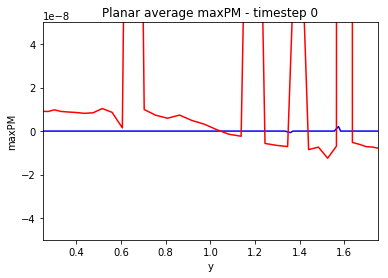

In [127]:
plotNaluvsNaluResAdeq(NaluResAdeqDF1,NaluResAdeqDF2,"maxPM",0,False,0.25,1.75,-0.00000005,0.00000005,True)

CDP - blue, Nalu - red


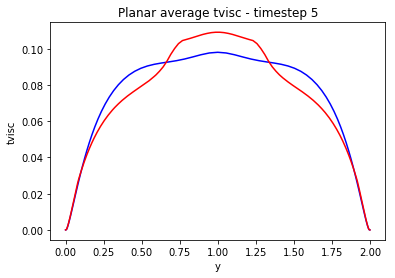

In [118]:
plotCDPvsNaluResAdeq(cdpResAdeqDF,NaluResAdeqDF,"tvisc",5,False,0.00,2.00,.005,2.002,False)

CDP - blue, Nalu - red


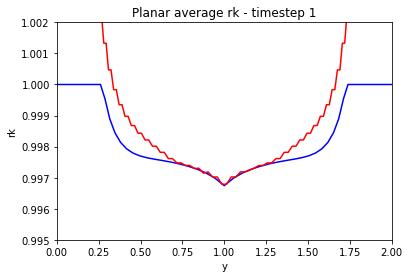

In [99]:
plotCDPvsNalu(cdpForceDF,NaluForceDF,"rk",1,False,0.00,2.00,1-.005,1.002,True)

In [156]:
def NaluTKESource(fname):
  dfS = pd.read_table(fname, delimiter='\[|,|\]\[|\]', engine='python', header=None, names=['trash1','x1','x2','x3','x4','y1','y2','y3','y4','z1','z2','z3','z4','Pk1','Pk2','Pk3','Pk4','Dk1','Dk2','Dk3','Dk4','Lk1','Lk2','Lk3','Lk4','visc1','visc2','visc3','visc4','minD1','minD2','minD3','minD4','tke1','tke2','tke3','tke4','tdr1','tdr2','tdr3','tdr4','trash2'])
    
  del dfS['trash1']
  del dfS['trash2']

  tsRows = (dfS.loc[(dfS['x1'] == dfS['x1'].values[0]) & (dfS['z1'] == dfS['z1'].values[0]) & (dfS['y1'] == dfS['y1'].values[0])]).index[1]
  print tsRows

  dfS['timestep'] = dfS.index/tsRows

  tmp1 = dfS.loc[:,['x1','y1','z1','Pk1','Dk1','Lk1','visc1','minD1','tke1','tdr1','timestep']]
  tmp2 = dfS.loc[:,['x2','y2','z2','Pk2','Dk2','Lk2','visc2','minD2','tke2','tdr2','timestep']]
  tmp3 = dfS.loc[:,['x3','y3','z3','Pk3','Dk3','Lk3','visc3','minD3','tke3','tdr3','timestep']]
  tmp4 = dfS.loc[:,['x4','y4','z4','Pk4','Dk4','Lk4','visc4','minD4','tke4','tdr4','timestep']]
  tmp1.columns = ['x','y','z','Pk','Dk','Lk','visc','minD','tke','tdr','timestep']
  tmp2.columns = ['x','y','z','Pk','Dk','Lk','visc','minD','tke','tdr','timestep']
  tmp3.columns = ['x','y','z','Pk','Dk','Lk','visc','minD','tke','tdr','timestep']  
  tmp4.columns = ['x','y','z','Pk','Dk','Lk','visc','minD','tke','tdr','timestep']  
  dfS = pd.concat([tmp1,tmp2,tmp3,tmp4])

  dfS["Lknew"] = -1*dfS["Lk"]/dfS["tke"]
  return dfS

def NaluTKESourcePlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  planarAvgForce = np.zeros((len(yCoords),9))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      Pk = sliceY.Pk.sum()/len(sliceY)
      Dk = sliceY.Dk.sum()/len(sliceY)
      Lktke = sliceY.Lk.sum()/len(sliceY)
      Lk = sliceY.Lknew.sum()/len(sliceY)
      visc = sliceY.visc.sum()/len(sliceY)
      minD = sliceY.minD.sum()/len(sliceY)
      tke = sliceY.tke.sum()/len(sliceY)
      tdr = sliceY.tdr.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,Pk,Dk,Lk,Lktke,visc,minD,tke,tdr])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','Pk','Dk','Lk','LkTKE','visc','minD','tke','tdr'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()
        
  return pltFrame


def CDPTKESource(basename,numProcs):
  for i in range(0,numProcs):
      fname = basename + str(i).zfill(3) + ".txt"
      #tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','forceX','forceY','forceZ','norm','v2','alpha','tke','tdr','rk','ux','uy','uz'])
      tmp = pd.read_table(fname,delim_whitespace=True,header=None,names=['x','y','z','Pk','Dk','Lk','visc','minD','tke','tdr'])
      tsRows = (tmp.loc[(tmp['x'] == tmp['x'].values[0]) & (tmp['z'] == tmp['z'].values[0]) & (tmp['y'] == tmp['y'].values[0])]).index[1]
      tmp['timestep'] = tmp.index/tsRows
      if (i == 0):
          dfS = tmp
      else:
          dfS = pd.concat([dfS,tmp])
  
  return dfS

def CDPTKESourcePlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  planarAvgForce = np.zeros((len(yCoords),8))
  index = 0
  for yc in yCoords:
  #for yc in xCoords:
      sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      #sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.49) & (df['y'] < 0.51) & (df['timestep'] == ts)]
      Pk = sliceY.Pk.sum()/len(sliceY)
      Dk = sliceY.Dk.sum()/len(sliceY)
      Lk = sliceY.Lk.sum()/len(sliceY)
      visc = sliceY.visc.sum()/len(sliceY)
      minD = sliceY.minD.sum()/len(sliceY)
      tke = sliceY.tke.sum()/len(sliceY)
      tdr = sliceY.tdr.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,Pk,Dk,Lk,visc,minD,tke,tdr])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y','Pk','Dk','Lk','visc','minD','tke','tdr'])
  pltFrame = pltFrame.sort_values(by=['y'])
    
  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      plt.show()

  else:
      return pltFrame


def plotCDPvsNaluTKESource(dfCDP,dfNalu,var,ts,save,xL,xH,yL,yH,customAxes):
  cdpPlot = CDPTKESourcePlot(dfCDP,var,ts,False,False)
  naluPlot = NaluTKESourcePlot(dfNalu,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(cdpPlot.y,cdpPlot[var],'b')
      ax.plot(naluPlot.y,naluPlot[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
  else:
      fig = plt.figure()
      ax1 = plt.subplot(311)
      ax1.plot(cdpPlot.y,cdpPlot['fxfx'],'b')
      ax1.plot(naluPlot.y,naluPlot['fxfx'],'r')
      ax1.set(xlabel='y',ylabel="%s" % 'fxfx',title="Planar average %s - timestep %i" % ('fxfx',ts)) 
      ax2 = plt.subplot(312)
      ax2.plot(cdpPlot.y,cdpPlot['fyfy'],'b')
      ax2.plot(naluPlot.y,naluPlot['fyfy'],'r')
      ax2.set(xlabel='y',ylabel="%s" % 'fyfy',title="Planar average %s - timestep %i" % ('fyfy',ts)) 
      ax3 = plt.subplot(313)
      ax3.plot(cdpPlot.y,cdpPlot['fzfz'],'b')
      ax3.plot(naluPlot.y,naluPlot['fzfz'],'r')
      ax3.set(xlabel='y',ylabel="%s" % 'fzfz',title="Planar average %s - timestep %i" % ('fzfz',ts)) 

  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/CDPvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()

In [157]:
cdpTKESourceDF = CDPTKESource("/workspace/jmelvin/Research/dataFiles/cdp-debugKEPS/tkeSource",96)
NaluTKESourceDF = NaluTKESource("/workspace/jmelvin/Research/dataFiles/nalu-debugKEPS/tkeSource.txt")

27078


CDP - blue, Nalu - red


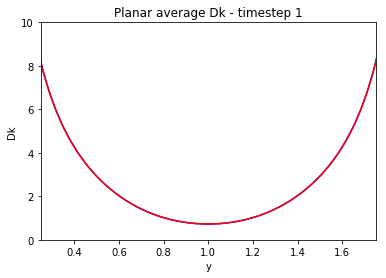

In [170]:
plotCDPvsNaluTKESource(cdpTKESourceDF,NaluTKESourceDF,"Dk",1,False,0.25,1.75,0,10,True)

In [73]:
def debugNaluResAdeq(fname):
  dfS = pd.read_table(fname, delim_whitespace=True,header=None, 
              names=['x','y','z',
                     'dudx11','dudx12','dudx13',
                     'dudx21','dudx22','dudx23',
                     'dudx31','dudx32','dudx33',
                     'avgDudx11','avgDudx12','avgDudx13',
                     'avgDudx21','avgDudx22','avgDudx23',
                     'avgDudx31','avgDudx32','avgDudx33'])

  tsRows = (dfS.loc[(dfS['x'] == dfS['x'].values[0]) & 
                    (dfS['z'] == dfS['z'].values[0]) & 
                    (dfS['y'] == dfS['y'].values[0])]).index[1]
  print tsRows

  dfS['timestep'] = dfS.index/tsRows

  return dfS

def debugNaluResAdeqPlot(df,var,ts,plotHere,save):
  zCoords = df.z.unique()
  yCoords = df.y.unique()
  xCoords = df.x.unique()
  timesteps = df.timestep.unique()

  #print yCoords

  planarAvgForce = np.zeros((len(yCoords),19))
  index = 0
    
  #for yc in yCoords:
  for yc in xCoords:
      #sliceY = df.loc[(df['y'] == yc) & (df['timestep'] == ts)]
      sliceY = df.loc[(df['x'] == yc) & (df['y'] > 0.95) & (df['y'] < 0.98) & (df['timestep'] == ts)]
      dudx11 = sliceY.dudx11.sum()/len(sliceY)
      dudx12 = sliceY.dudx12.sum()/len(sliceY)
      dudx13 = sliceY.dudx13.sum()/len(sliceY)
      dudx21 = sliceY.dudx21.sum()/len(sliceY)
      dudx22 = sliceY.dudx22.sum()/len(sliceY)
      dudx23 = sliceY.dudx23.sum()/len(sliceY)
      dudx31 = sliceY.dudx31.sum()/len(sliceY)
      dudx32 = sliceY.dudx32.sum()/len(sliceY)
      dudx33 = sliceY.dudx33.sum()/len(sliceY)
      avgDudx11 = sliceY.avgDudx11.sum()/len(sliceY)
      avgDudx12 = sliceY.avgDudx12.sum()/len(sliceY)
      avgDudx13 = sliceY.avgDudx13.sum()/len(sliceY)
      avgDudx21 = sliceY.avgDudx21.sum()/len(sliceY)
      avgDudx22 = sliceY.avgDudx22.sum()/len(sliceY)
      avgDudx23 = sliceY.avgDudx23.sum()/len(sliceY)
      avgDudx31 = sliceY.avgDudx31.sum()/len(sliceY)
      avgDudx32 = sliceY.avgDudx32.sum()/len(sliceY)
      avgDudx33 = sliceY.avgDudx33.sum()/len(sliceY)
      planarAvgForce[index] = np.array([yc,
                                        dudx11,dudx12,dudx13,
                                        dudx21,dudx22,dudx23,
                                        dudx31,dudx32,dudx33,
                                        avgDudx11,avgDudx12,avgDudx13,
                                        avgDudx21,avgDudx22,avgDudx23,
                                        avgDudx31,avgDudx32,avgDudx33])
      index = index + 1
  pltFrame = pd.DataFrame(planarAvgForce,columns=['y',
                     'dudx11','dudx12','dudx13',
                     'dudx21','dudx22','dudx23',
                     'dudx31','dudx32','dudx33',
                     'avgDudx11','avgDudx12','avgDudx13',
                     'avgDudx21','avgDudx22','avgDudx23',
                     'avgDudx31','avgDudx32','avgDudx33'])
  pltFrame = pltFrame.sort_values(by=['y'])

  if (plotHere):
      fig, ax = plt.subplots()
      ax.plot(pltFrame.y,pltFrame[var])
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))

      if (save):
          plt.savefig('/workspace/jmelvin/Research/channelFlow/alphaMovies/nalu_' + str(ts).zfill(4))
          plt.close(fig)
      else:
          plt.show()
        
  return pltFrame
    
def debugPlotNaluvsNaluResAdeq(dfNalu1,dfNalu2,var,ts,save,xL,xH,yL,yH,customAxes):
  naluPlot1 = debugNaluResAdeqPlot(dfNalu1,var,ts,False,False)
  naluPlot2 = debugNaluResAdeqPlot(dfNalu2,var,ts,False,False)
  if (var != "forcing"):
      fig, ax = plt.subplots()
      ax.plot(naluPlot1.y,naluPlot1[var],'b')
      ax.plot(naluPlot2.y,naluPlot2[var],'r')
      ax.set(xlabel='y',ylabel="%s" % var,title="Planar average %s - timestep %i" % (var,ts))
      if (customAxes):
        ax.set_xlim(xL,xH)
        ax.set_ylim(yL,yH)
        
  if (save):
      plt.tight_layout()
      plt.savefig('/workspace/jmelvin/Research/dataAnalysis/NaluvsNalu_' + var + "_" + str(ts).zfill(4))
      plt.close(fig)
  else:
      print "CDP - blue, Nalu - red"
      plt.show()

In [70]:
NaluResAdeqDF1 = debugNaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-wtfElem.txt")
NaluResAdeqDF2 = debugNaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq-wtfNode.txt")

13500
16226


CDP - blue, Nalu - red


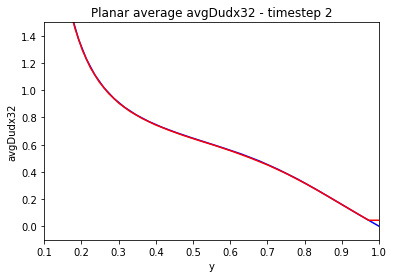

In [93]:
debugPlotNaluvsNaluResAdeq(NaluResAdeqDF1,NaluResAdeqDF2,"avgDudx32",2,False,0.1,1.0,-0.1,1.5,True)

In [59]:
NaluResAdeqDF = debugNaluResAdeq("/workspace/jmelvin/Research/dataFiles/Nalu-nodalMij/resAdeq.txt")

16224


CDP - blue, Nalu - red


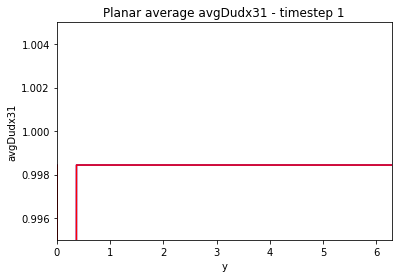

In [74]:
debugPlotNaluvsNaluResAdeq(NaluResAdeqDF,NaluResAdeqDF,"avgDudx31",1,False,0.0,6.29,0.995,1.005,True)

In [96]:
NaluForceDF.loc[(NaluForceDF['timestep'] == 0) & (NaluForceDF['y'] == 0.617747) & (NaluForceDF['z'] > 0.687222) & (NaluForceDF['z'] < 0.687224) ]

,x,y,z,forceX,forceY,forceZ,norm,alpha,v2,tke,tdr,rk,ux,uy,uz,timestep,fxfx,fyfy,fzfz
90,3.788390,0.617747,0.687223,0.000228,-0.000008,-0.000015,0.000716,8.22879,1,0,-0.000087,0.999826,-0.000087,0.072193,-0.000087,0,5.190560e-08,6.262712e-11,2.385913e-10
126,3.973190,0.617747,0.687223,0.000073,-0.000006,-0.000013,0.000239,8.22879,1,0,-0.000029,0.999942,-0.000029,0.024064,-0.000029,0,5.311203e-09,4.125853e-11,1.571964e-10
2112,5.636390,0.617747,0.687223,-0.000632,-0.000406,-0.000795,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,3.998766e-07,1.648863e-07,6.316848e-07
2148,5.821190,0.617747,0.687223,-0.000894,-0.000367,-0.000719,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,7.994398e-07,1.347778e-07,5.169524e-07
19094,2.309990,0.617747,0.687223,0.000087,0.000108,0.000211,0.001256,8.22879,1,0,-0.000153,0.999695,-0.000153,0.137743,-0.000153,0,7.605340e-09,1.165191e-08,4.440460e-08
19130,2.494790,0.617747,0.687223,0.000474,0.000305,0.000596,0.003770,8.22879,1,0,-0.000458,0.999084,-0.000458,0.413229,-0.000458,0,2.248192e-07,9.322274e-08,3.551147e-07
20034,0.831598,0.617747,0.687223,-0.000384,0.000034,0.000066,0.001256,8.22879,1,0,-0.000153,0.999695,-0.000153,0.137743,-0.000153,0,1.470784e-07,1.136897e-09,4.353585e-09
20070,1.016400,0.617747,0.687223,-0.001064,0.000157,0.000308,0.003770,8.22879,1,0,-0.000458,0.999084,-0.000458,0.413229,-0.000458,0,1.131139e-06,2.480436e-08,9.486646e-08
20843,1.940400,0.617747,0.687223,-0.000243,0.000437,0.000854,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,5.909372e-08,1.912986e-07,7.294817e-07
20879,2.125200,0.617747,0.687223,0.000054,0.000442,0.000863,0.005028,8.22879,1,0,-0.000611,0.998779,-0.000611,0.550972,-0.000611,0,2.906407e-09,1.955851e-07,7.456167e-07


In [106]:
NaluResAdeqDF.loc[(NaluResAdeqDF['timestep'] == 0) & (NaluResAdeqDF['y'] >= 0.605741) & (NaluResAdeqDF['y'] <= 0.653764) & (NaluResAdeqDF['z'] >= 0.392698) & (NaluResAdeqDF['z'] <= 0.785398) ]

,x,y,z,dudx11,dudx12,dudx13,dudx21,dudx22,dudx23,dudx31,...,avgDudx11,avgDudx12,avgDudx13,avgDudx21,avgDudx22,avgDudx23,avgDudx31,avgDudx32,avgDudx33,timestep
17,3.695990,0.653764,0.785398,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513375,9.087680e-10,1.000000,0.513375,0.998762,0
53,3.326390,0.653764,0.785398,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513375,-2.149140e-08,1.000000,0.513375,0.998762,0
58,5.913590,0.605741,0.392699,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,1.038480e-07,1.000000,0.563504,0.998785,0
94,5.543990,0.605741,0.392699,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,4.933600e-08,1.000000,0.563504,0.998785,0
130,5.174390,0.605741,0.392699,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,5.784760e-08,1.000000,0.563504,0.998785,0
166,5.913590,0.605741,0.785398,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,1.791490e-07,1.000000,0.563504,0.998785,0
202,5.543990,0.605741,0.785398,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,9.877530e-08,1.000000,0.563504,0.998785,0
238,5.174390,0.605741,0.785398,0.091892,1,1.42284,1.98093,1,0.718270,0.369599,...,0.265241,0.016978,0.287572,0,0.563504,8.416920e-08,1.000000,0.563504,0.998785,0
382,5.913590,0.653764,0.392699,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513374,8.596920e-08,1.000000,0.513374,0.998762,0
418,5.543990,0.653764,0.392699,0.092588,1,1.30901,1.66470,1,0.786332,0.369599,...,0.265241,0.017913,0.287572,0,0.513374,4.140980e-08,1.000000,0.513374,0.998762,0


In [108]:
(NaluResAdeqDF.loc[(NaluResAdeqDF['x'] == NaluResAdeqDF['x'].values[0]) & 
                    (NaluResAdeqDF['z'] == NaluResAdeqDF['z'].values[0]) & 
                    (NaluResAdeqDF['y'] == NaluResAdeqDF['y'].values[0])])

,x,y,z,dudx11,dudx12,dudx13,dudx21,dudx22,dudx23,dudx31,...,avgDudx11,avgDudx12,avgDudx13,avgDudx21,avgDudx22,avgDudx23,avgDudx31,avgDudx32,avgDudx33,timestep
0,2.95679,1.44026,0.392699,0.091042,1,1.54070,2.34283,1,0.657623,0.369599,...,0.265241,0.015982,0.287572,0,0.607596,-1.440100e-08,1.000000,0.607596,0.998807,0
16224,2.95679,1.44026,0.392699,0.081550,1,1.59005,2.34065,1,0.570774,0.369599,...,0.265241,0.015982,0.287572,0,0.591153,2.703220e-06,0.998807,0.591153,0.997378,1
32426,2.95679,1.44026,0.392699,0.081227,1,1.58376,2.34167,1,0.570774,0.369599,...,0.265241,0.015982,0.287572,0,0.592265,2.098820e-06,0.997378,0.592265,0.995959,1
48624,2.95679,1.44026,0.392699,0.081267,1,1.58454,2.34123,1,0.570773,0.369599,...,0.265241,0.015982,0.287572,0,0.592135,2.666990e-06,0.995959,0.592135,0.994544,2
64822,2.95679,1.44026,0.392699,0.081262,1,1.58445,2.34141,1,0.570772,0.369599,...,0.265241,0.015982,0.287572,0,0.592152,3.032140e-06,0.994544,0.592152,0.993134,3
81023,2.95679,1.44026,0.392699,0.082105,1,1.60089,2.33911,1,0.570772,0.369599,...,0.265241,0.015982,0.287572,0,0.589372,6.089330e-06,0.993134,0.589372,0.991719,4
97224,2.95679,1.44026,0.392699,0.081985,1,1.59854,2.34010,1,0.570770,0.369599,...,0.265241,0.015982,0.287572,0,0.589747,6.652230e-06,0.991719,0.589747,0.990310,5
113425,2.95679,1.44026,0.392699,0.082002,1,1.59887,2.33968,1,0.570769,0.369599,...,0.265241,0.015982,0.287572,0,0.589701,7.073100e-06,0.990310,0.589701,0.988907,6
129624,2.95679,1.44026,0.392699,0.081999,1,1.59882,2.33985,1,0.570768,0.369599,...,0.265241,0.015982,0.287572,0,0.589709,7.570470e-06,0.988907,0.589709,0.987508,7
145824,2.95679,1.44026,0.392699,0.082268,1,1.60406,2.33752,1,0.570766,0.369599,...,0.265241,0.015982,0.287572,0,0.589030,1.389420e-05,0.987508,0.589030,0.986111,8
